1. using electricity data first for now
2. imputing mean/median for missing data
3. Making electricity usage for each hours "independent" (? would this be the right terminology? I'm not sure)
    - what I am trying to convey here is that I am training for each individual electricity usage based on building  characteristics and weather data.
    - is this the correct way to model time series data? I don't know.
    - After I am done with this method, I can compare the predictions for a day/month
    
    
Should I distinguish between the meters? a model for each meter?
- it may be better to model for each type of meter
    - one interesting question is:
        - do different features matter for each meter?
            - doing separate models for each meter could help us answer this question
            - prior to modeling, how could I find this out?
                - in the correlations for each type of meter

# Imports

In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
import datetime

# Load Data

In [2]:
electricity_data = pd.read_csv('data_meter_0.csv')
electricity_data=electricity_data.drop(['Unnamed: 0'],axis=1)
electricity_data=electricity_data.drop(['meter_reading_log'],axis=1)
electricity_data.head()

,site_id,building_id,primary_use,meter,timestamp,meter_reading,square_feet,year_built,floor_count,air_temperature,dew_temperature,cloud_coverage,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,Education,0,2016-01-01 00:00:00,0.0,7432,2008.0,NaN,25.0,20.0,6.0,NaN,1019.7,0.0,0.0
1,0,1,Education,0,2016-01-01 00:00:00,0.0,2720,2004.0,NaN,25.0,20.0,6.0,NaN,1019.7,0.0,0.0
2,0,2,Education,0,2016-01-01 00:00:00,0.0,5376,1991.0,NaN,25.0,20.0,6.0,NaN,1019.7,0.0,0.0
3,0,3,Education,0,2016-01-01 00:00:00,0.0,23685,2002.0,NaN,25.0,20.0,6.0,NaN,1019.7,0.0,0.0
4,0,4,Education,0,2016-01-01 00:00:00,0.0,116607,1975.0,NaN,25.0,20.0,6.0,NaN,1019.7,0.0,0.0


# Train/Test Split

Here I will split the data into 70% for training and 30% for testing. 

In [4]:
X_train, X_test, y_train, y_test = train_test_split(electricity_data.drop(columns='meter_reading'), 
                                                    electricity_data.meter_reading, test_size=0.3, 
                                                    random_state=47)

Here I will drop the categorical variables so that the training is only done with numerical variables. 
The only one categorical variable that could be relevant is **'primary_use'**. 

How do I assess if I need **'primary_use'**?
- does the type of building determine the energy usage?
- if so, can the type of building be explained by the building characteristics?
- I could check for this, but for starters (just common sense...):
    - if the type of building matters, then this is likely explained by building characteristics and the only thing that matters is building characteristics for prediction. At the end of the day, building characteristics is more informative than just building type...
        - for example, it makes sense that a small high school will use less energy than a larger campus. 
    - if the type of building doesn't matter, then it doesn't matter to keep it!

- my conclusion is we don't need the type of building for prediction
    - at the end of the day, the way we use the type of building is to learn about our the type of data we have

In [5]:
categ_list = ['site_id','building_id','primary_use','meter','timestamp']
categ_train = X_train[['site_id','building_id','primary_use','meter','timestamp']]
categ_test = X_test[['site_id','building_id','primary_use','meter','timestamp']]
X_train.drop(columns=categ_list, inplace=True)
X_test.drop(columns=categ_list, inplace=True)
X_train.shape, X_test.shape

((8412185, 10), (3605223, 10))

In [6]:
X_train.dtypes

square_feet             int64
year_built            float64
floor_count           float64
air_temperature       float64
dew_temperature       float64
cloud_coverage        float64
precip_depth_1_hr     float64
sea_level_pressure    float64
wind_direction        float64
wind_speed            float64
dtype: object

# Using the mean as a predictor

Do this manually first:

In [29]:
#Calculate the mean of `y_train`
train_mean = y_train.mean()
train_mean

170.52851156556196

Using DummyRegressor:

In [30]:
dumb_reg = DummyRegressor(strategy='mean')
dumb_reg.fit(X_train, y_train)
dumb_reg.constant_

array([[170.52851157]])

How good is this? How closely does this match, or explain, the actual values? Use the root mean squared error to assess this

In [31]:
y_tr_pred = dumb_reg.predict(X_train)

In [32]:
y_te_pred = train_mean * np.ones(len(y_test))

In [33]:
(mean_squared_error(y_train, y_tr_pred))**(1/2), (mean_squared_error(y_test, y_te_pred))**(1/2)

(377.9482054111115, 383.2159040478373)

# Imputing missing feature (predictor) values

For now, I am going to impute the mean/median of all of the data for the features. How good of an approach is this? What would be a better approach? This is something I will think about. But this is a good starting point. I am doing this for now to get the hang of the modeling process and see what the results will be, then assess how the model can be improved. By looking at where this method is going wrong, I can assess how to improve it.

I am going to start with the median. What do these values look like?

In [35]:
X_defaults_median = X_train.median()
X_defaults_median

square_feet           57811.0
year_built             1970.0
floor_count               3.0
air_temperature          16.7
dew_temperature           9.4
cloud_coverage            2.0
precip_depth_1_hr         0.0
sea_level_pressure     1016.5
wind_direction          180.0
wind_speed                3.1
dtype: float64

Next, I will apply the imputation to both train and test splits

In [36]:
#Call `X_train` and `X_test`'s `fillna()` method, passing `X_defaults_median` as the values to use
#Assign the results to `X_tr` and `X_te`, respectively
X_tr = X_train.fillna(X_defaults_median)
X_te = X_test.fillna(X_defaults_median)

# Scale the data

scale each feature to zero mean and unit variance.

In [37]:
#Call the StandardScaler`s fit method on `X_tr` to fit the scaler
#then use it's `transform()` method to apply the scaling to both the train and test split
#data (`X_tr` and `X_te`), naming the results `X_tr_scaled` and `X_te_scaled`, respectively
scaler = StandardScaler()
scaler.fit(X_tr)
X_tr_scaled = scaler.transform(X_tr)
X_te_scaled = scaler.transform(X_te)

# Train the linear model

In [38]:
lm = LinearRegression().fit(X_tr_scaled, y_train)

In [39]:
#Call the `predict()` method of the model (`lm`) on both the (scaled) train and test data
#Assign the predictions to `y_tr_pred` and `y_te_pred`, respectively
y_tr_pred = lm.predict(X_tr_scaled)
y_te_pred = lm.predict(X_te_scaled)

In [40]:
# r^2 - train, test
median_r2 = r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)
median_r2

(0.3239618027413934, 0.31839448592278174)

In [41]:
#Now calculate the mean absolute error scores using `sklearn`'s `mean_absolute_error` function
# as we did above for R^2
# MAE - train, test
median_mae = mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)
median_mae

(128.22769997048042, 128.43582455385135)

In [42]:
#And also do the same using `sklearn`'s `mean_squared_error`
# MSE - train, test
median_rmse = (mean_squared_error(y_train, y_tr_pred))**(1/2), (mean_squared_error(y_test, y_te_pred))**(1/2)
median_rmse

(310.75484253603287, 316.3806406425954)

# Now impute with the mean

In [43]:
#As we did for the median above, calculate mean values for imputing missing values
# These are the values we'll use to fill in any missing values
X_defaults_mean = X_train.mean()
X_defaults_mean

square_feet           92716.946863
year_built             1968.369372
floor_count               3.793200
air_temperature          16.008024
dew_temperature           8.335770
cloud_coverage            2.284371
precip_depth_1_hr         0.927220
sea_level_pressure     1016.407307
wind_direction          176.333300
wind_speed                3.558914
dtype: float64

In [44]:
X_tr = X_train.fillna(X_defaults_mean)
X_te = X_test.fillna(X_defaults_mean)
scaler = StandardScaler()
scaler.fit(X_tr)
X_tr_scaled = scaler.transform(X_tr)
X_te_scaled = scaler.transform(X_te)
lm = LinearRegression().fit(X_tr_scaled, y_train)
y_tr_pred = lm.predict(X_tr_scaled)
y_te_pred = lm.predict(X_te_scaled)

In [45]:
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

(0.3216059320342113, 0.3160238149240162)

In [46]:
mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)

(129.6367454027631, 129.84680695928893)

In [47]:
(mean_squared_error(y_train, y_tr_pred))**(1/2), (mean_squared_error(y_test, y_te_pred))**(1/2)

(311.2958338106943, 316.93035991400234)

Whether we use the mean or the median to fill in the missing values, the performance of the model does not change at all.

# Use a pipeline

In [48]:
pipe = make_pipeline(
    SimpleImputer(strategy='median'), 
    StandardScaler(), 
    LinearRegression()
)

Fit the pipeline

In [49]:
#Call the pipe's `fit()` method with `X_train` and `y_train` as arguments
pipe.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

Make predictions on the train and test sets

In [50]:
y_tr_pred = pipe.predict(X_train)
y_te_pred = pipe.predict(X_test)

In [51]:
(mean_squared_error(y_train, y_tr_pred))**(1/2), (mean_squared_error(y_test, y_te_pred))**(1/2)

(310.75484253603287, 316.3806406425954)

# Refining the linear model

The performance of the model above is very poor. We will try using just 5 features

In [54]:
#Add `SelectKBest` as a step in the pipeline between `StandardScaler()` and `LinearRegression()`
#Don't forget to tell it to use `f_regression` as its score function
pipe = make_pipeline(
    SimpleImputer(strategy='median'), 
    StandardScaler(),
    SelectKBest(f_regression, k=5),
    LinearRegression()
)

In [55]:
pipe.fit(X_train, y_train)
y_tr_pred = pipe.predict(X_train)
y_te_pred = pipe.predict(X_test)
(mean_squared_error(y_train, y_tr_pred))**(1/2), (mean_squared_error(y_test, y_te_pred))**(1/2)

(310.8884481629098, 316.5091908709752)

# Hyperparameter search using GridSearchCV

The performance with 5 features is still very poor. Next, we will use GridSearchCV to do a cross-validation and select the optimal number of features for the model.

In [56]:
k = [k+1 for k in range(len(X_train.columns))]
grid_params = {'selectkbest__k': k}
lr_grid_cv= GridSearchCV(pipe,param_grid=grid_params, cv=10, n_jobs=-1)
lr_grid_cv.fit(X_train,y_train)

C:\Users\Melissa\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


MemoryError: Unable to allocate 28.9 MiB for an array with shape (7570967,) and data type int32

This ran out of memory... But the performance was so poor I am going to move on

# Feature engineering: add time as a feature

In [3]:
electricity_data['timestamp']=pd.to_datetime(electricity_data['timestamp'],format='%Y-%m-%d %H:%M:%S')

In [6]:
electricity_data.dtypes

site_id                        int64
building_id                    int64
primary_use                   object
meter                          int64
timestamp             datetime64[ns]
meter_reading                float64
square_feet                    int64
year_built                   float64
floor_count                  float64
air_temperature              float64
dew_temperature              float64
cloud_coverage               float64
precip_depth_1_hr            float64
sea_level_pressure           float64
wind_direction               float64
wind_speed                   float64
dtype: object

In [4]:
electricity_data['month']=electricity_data['timestamp'].dt.month
electricity_data['day']=electricity_data['timestamp'].dt.day
electricity_data['dayofweek']=electricity_data['timestamp'].dt.dayofweek
electricity_data['hour']=electricity_data['timestamp'].dt.hour
electricity_data['minute']=electricity_data['timestamp'].dt.minute

In [7]:
X_train, X_test, y_train, y_test = train_test_split(electricity_data.drop(columns='meter_reading'), 
                                                    electricity_data.meter_reading, test_size=0.3, 
                                                    random_state=47)

In [9]:
X_train.dtypes

site_id                        int64
building_id                    int64
primary_use                   object
meter                          int64
timestamp             datetime64[ns]
square_feet                    int64
year_built                   float64
floor_count                  float64
air_temperature              float64
dew_temperature              float64
cloud_coverage               float64
precip_depth_1_hr            float64
sea_level_pressure           float64
wind_direction               float64
wind_speed                   float64
month                          int64
day                            int64
dayofweek                      int64
hour                           int64
minute                         int64
dtype: object

In [16]:
categ_list = ['site_id','building_id','primary_use','meter','timestamp']
categ_train = X_train[['site_id','building_id','primary_use','meter','timestamp']]
categ_test = X_test[['site_id','building_id','primary_use','meter','timestamp']]
X_train.drop(columns=categ_list, inplace=True)
X_test.drop(columns=categ_list, inplace=True)

## Imputing missing feature (predictor) values

Here I will use the median values I had calculated previously to fill the missing values

In [15]:
pipe = make_pipeline(
    SimpleImputer(strategy='median'), 
    StandardScaler(), 
    LinearRegression()
)

In [16]:
pipe.fit(X_train,y_train);

In [17]:
y_tr_pred=pipe.predict(X_train)
y_te_pred=pipe.predict(X_test)
(mean_squared_error(y_train, y_tr_pred))**(1/2), (mean_squared_error(y_test, y_te_pred))**(1/2)

(310.3068399016644, 315.9341394594252)

In [12]:
pipe=make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler(),
    SelectKBest(f_regression),
    LinearRegression()
)

In [21]:
k = [k+1 for k in range(len(X_train.columns))]
grid_params = {'selectkbest__k': k}
lr_grid_cv= GridSearchCV(pipe,param_grid=grid_params, cv=10, n_jobs=-1)
lr_grid_cv.fit(X_train,y_train)

MemoryError: Unable to allocate 57.8 MiB for an array with shape (7570966,) and data type int64

I am running out of memory, so I am going to take out a sample from the training data

In [19]:
X_train_subsample=X_train.sample(frac=0.25,random_state=123)
X_train_subsample.head()

,square_feet,year_built,floor_count,air_temperature,dew_temperature,cloud_coverage,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,month,day,dayofweek,hour,minute
4185559,3267,NaN,NaN,22.2,19.4,8.0,NaN,1007.9,20.0,3.6,6,16,3,12,0
1159124,36240,2010.0,NaN,22.8,20.6,2.0,0.0,1017.6,20.0,2.6,10,13,3,2,0
3347508,235000,2013.0,NaN,3.3,-5.0,NaN,0.0,1026.7,200.0,3.6,2,7,6,1,0
1010109,105545,2001.0,NaN,23.9,21.7,0.0,0.0,1020.0,60.0,2.1,9,7,2,8,0
1516354,30495,1997.0,8.0,8.5,0.6,NaN,NaN,1014.6,260.0,9.3,2,2,1,16,0


In [14]:
X_train_subsample.index

Int64Index([ 4185559,  1159124,  3347508,  1010109,  1516354,  2210383,
            10861694,  3823735, 11302814,  1067664,
            ...
            10146979,  8768826,  6734590,  2964751,  9364888,  2514411,
             9861352,  3184659,  8536386,  4925374],
           dtype='int64', length=4206092)

In [20]:
y_train_subsample=y_train.loc[X_train_subsample.index]

In [21]:
k = [k+1 for k in range(len(X_train_subsample.columns))]
grid_params = {'selectkbest__k': k}
lr_grid_cv= GridSearchCV(pipe,param_grid=grid_params, cv=10, n_jobs=-1)
lr_grid_cv.fit(X_train_subsample,y_train_subsample)

C:\Users\Melissa\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('simpleimputer',
                                        SimpleImputer(strategy='median')),
                                       ('standardscaler', StandardScaler()),
                                       ('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x00000207B1524DC0>)),
                                       ('linearregression',
                                        LinearRegression())]),
             n_jobs=-1,
             param_grid={'selectkbest__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                            12, 13, 14, 15]})

In [22]:
score_mean = lr_grid_cv.cv_results_['mean_test_score']
score_std = lr_grid_cv.cv_results_['std_test_score']
cv_k = [k for k in lr_grid_cv.cv_results_['param_selectkbest__k']]

In [23]:
lr_grid_cv.best_params_

{'selectkbest__k': 15}

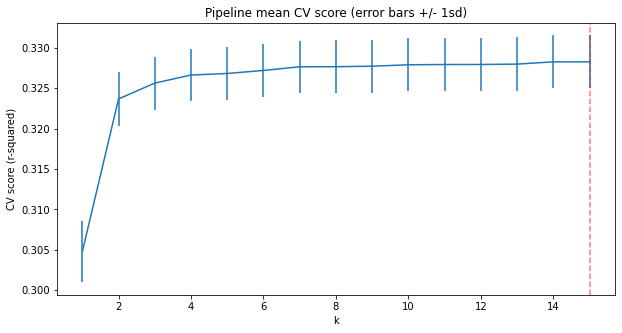

In [24]:
best_k = lr_grid_cv.best_params_['selectkbest__k']
plt.subplots(figsize=(10, 5))
plt.errorbar(cv_k, score_mean, yerr=score_std)
plt.axvline(x=best_k, c='r', ls='--', alpha=.5)
plt.xlabel('k')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)');

The performance is not very good. It looks like we only need up to 3 features. The model could also very much benefit from more feature engineering and a better way to fill in the missing values.

In [25]:
selected = lr_grid_cv.best_estimator_.named_steps.selectkbest.get_support()

In [26]:
coefs = lr_grid_cv.best_estimator_.named_steps.linearregression.coef_
features = X_train.columns[selected]
pd.Series(coefs, index=features).sort_values(ascending=False)

square_feet           193.997393
floor_count            53.421701
year_built             16.847022
month                  11.236817
dew_temperature        10.887999
hour                    9.719485
cloud_coverage          4.170737
precip_depth_1_hr       1.596436
wind_direction          1.027104
day                     0.926780
minute                  0.000000
sea_level_pressure     -1.708926
wind_speed             -2.522267
dayofweek              -8.710246
air_temperature       -11.029932
dtype: float64

Here it seems the most important features are building characteristics such as **floor_count**, **square_feet**, and **year_built**. Note that we are missing 75% of **floor_count** and these were replaced with the median value. The more important weather features are **dew_temperature** and **air_temperature**. These have opposite correlations with energy usage. Why? **dew_temperature** and **air_temperature** are positively correlated with a pearson correlation of ~ 0.8. Time features like **month** (season) and **dayofweek** are most important.  

In [ ]:
y_tr_pred = pipe.predict(X_train)
y_te_pred = pipe.predict(X_test)
(mean_squared_error(y_train, y_tr_pred))**(1/2), (mean_squared_error(y_test, y_te_pred))**(1/2)

# Random Forest Model

In [18]:
RF_pipe = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler(),
    RandomForestRegressor(n_estimators=1000,random_state=47)
)

This fitting takes a long time to run and I run out of memory. I have tried randomly picking 50%, 25%, and 10% of the data. I will now try 1% which is ~100,000 rows. 

In [12]:
100000/len(X_train)

0.011887517927862974

In [17]:
X_train_subsample=X_train.sample(100000,random_state=123)
y_train_subsample=y_train.loc[X_train_subsample.index]
X_train_subsample.head()

,square_feet,year_built,floor_count,air_temperature,dew_temperature,cloud_coverage,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,month,day,dayofweek,hour,minute
4185559,3267,NaN,NaN,22.2,19.4,8.0,NaN,1007.9,20.0,3.6,6,16,3,12,0
1159124,36240,2010.0,NaN,22.8,20.6,2.0,0.0,1017.6,20.0,2.6,10,13,3,2,0
3347508,235000,2013.0,NaN,3.3,-5.0,NaN,0.0,1026.7,200.0,3.6,2,7,6,1,0
1010109,105545,2001.0,NaN,23.9,21.7,0.0,0.0,1020.0,60.0,2.1,9,7,2,8,0
1516354,30495,1997.0,8.0,8.5,0.6,NaN,NaN,1014.6,260.0,9.3,2,2,1,16,0


In [31]:
RF_pipe.fit(X_train_subsample,y_train_subsample)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(n_estimators=1000, random_state=47))])

In [19]:
rf_default_cv_results=cross_validate(RF_pipe,X_train_subsample,y_train_subsample,cv=10)

In [20]:
rf_cv_scores=rf_default_cv_results['test_score']
rf_cv_scores

array([0.93991974, 0.95647632, 0.92481731, 0.92630896, 0.94841907,
       0.94151343, 0.92608746, 0.94828799, 0.9451515 , 0.93064273])

In [21]:
np.mean(rf_cv_scores), np.std(rf_cv_scores)

(0.9387624525140797, 0.010600169420860677)

In [45]:
RF_pipe.named_steps['randomforestregressor'].feature_importances_

array([5.85964647e-01, 8.38806847e-02, 1.41325182e-01, 1.70935852e-02,
       4.30781046e-02, 1.32104547e-03, 4.38824007e-04, 8.17589258e-03,
       6.13021832e-03, 4.30158689e-03, 7.05993634e-02, 6.55684029e-03,
       1.07312984e-02, 2.04027264e-02, 0.00000000e+00])

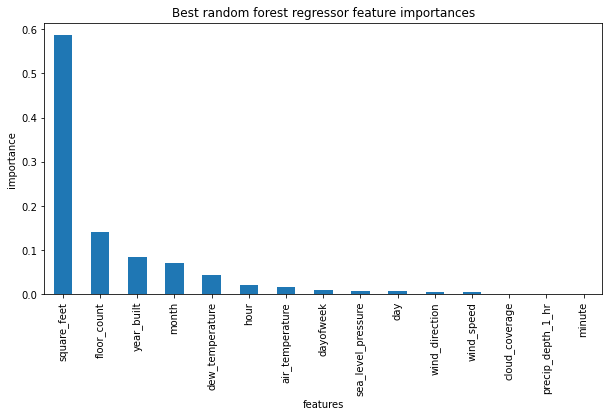

In [46]:
plt.subplots(figsize=(10, 5))
#imps = RF_pipe.best_estimator_.named_steps.randomforestregressor.feature_importances_
#imps = RF_pipe.named_steps.randomforestregressor.feature_importances_
imps = RF_pipe.named_steps['randomforestregressor'].feature_importances_
rf_feat_imps = pd.Series(imps, index=X_train_subsample.columns).sort_values(ascending=False)
rf_feat_imps.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best random forest regressor feature importances');

The most important features identified by the random forest model are square_feet, floor_count, year_built, and month, as predicted by the linear regression model. 

In [50]:
y_tr_pred = RF_pipe.predict(X_train_subsample)
y_te_pred = RF_pipe.predict(X_test)
(mean_squared_error(y_train_subsample, y_tr_pred))**(1/2), (mean_squared_error(y_test, y_te_pred))**(1/2)

(33.46977535958175, 113.21072126249986)

The RMSE for the RF model is quite better than LR, but still quite off... The difference is pretty large when comparing the RMSE of the training subsample compared to the testing data.

In [56]:
y_tr_pred = RF_pipe.predict(X_train)
(mean_squared_error(y_train, y_tr_pred))**(1/2)

101.28831926297423

# Hyperparameter Search using GridSearchCV

In [17]:
#n_est=[int(n) for n in np.logspace(start=1, stop=3, num=20)]
grid_params={'randomforestregressor__n_estimators':[1000],
            'standardscaler':[StandardScaler(),None],
            'simpleimputer__strategy':['mean','median']}

In [ ]:
rf_grid_cv=GridSearchCV(RF_pipe,param_grid=grid_params,cv=10,n_jobs=-1)
rf_grid_cv.fit(X_train_subsample,y_train_subsample)

took a very long time and my computer froze and shut down

In [ ]:
rf_grid_cv.best_params_

In [ ]:
rf_best_cv_results=cross_validate(rf_grid_cv.best_estimator_,X_train_subsample,y_train_subsample,cv=10)
rf_best_scores=rf_best_cv_results['test_score']
rf_best_scores

In [ ]:
np.mean(rf_best_scores), np.std(rf_best_scores)

Where to go from here?

- Try ridge regression 
- Look at the other meters
    - having a model for each meter can help us determine which features matter most for each  
- What are the problems I am running into?
    - should the time series data stay together?
        - I think so, but I am trying to figure out how to do that
    - memory issues: is the best strategy to sample from training set, then test model on training set and testing set?
- Floor_count seems to matter, but we are missing 75% of the data. 
    - Take this feature out or how should I fill in? 
- Reasearch methods for filling out missing data in time series data
